# Problem: Predicting Airplane Delays

The goals of this notebook are:
- Process and create a dataset from downloaded ZIP files
- Exploratory data analysis (EDA)
- Establish a baseline model and improve it

## Introduction to business scenario
You work for a travel booking website that is working to improve the customer experience for flights that were delayed. The company wants to create a feature to let customers know if the flight will be delayed due to weather when the customers are booking the flight to or from the busiest airports for domestic travel in the US. 

You are tasked with solving part of this problem by leveraging machine learning to identify whether the flight will be delayed due to weather. You have been given access to the a dataset of on-time performance of domestic flights operated by large air carriers. You can use this data to train a machine learning model to predict if the flight is going to be delayed for the busiest airports.

### Dataset
The provided dataset contains scheduled and actual departure and arrival times reported by certified US air carriers that account for at least 1 percent of domestic scheduled passenger revenues. The data was collected by the Office of Airline Information, Bureau of Transportation Statistics (BTS). The dataset contains date, time, origin, destination, airline, distance, and delay status of flights for flights between 2014 and 2018.
The data are in 60 compressed files, where each file contains a CSV for the flight details in a month for the five years (from 2014 - 2018). The data can be downloaded from this link: [https://ucstaff-my.sharepoint.com/:f:/g/personal/ibrahim_radwan_canberra_edu_au/Er0nVreXmihEmtMz5qC5kVIB81-ugSusExPYdcyQTglfLg?e=bNO312]. Please download the data files and place them on a relative path. Dataset(s) used in this assignment were compiled by the Office of Airline Information, Bureau of Transportation Statistics (BTS), Airline On-Time Performance Data, available with the following link: [https://www.transtats.bts.gov/Fields.asp?gnoyr_VQ=FGJ]. 

In [1]:
bucket='c94466a2114436l5157475t1w966381863332-labbucket-f7gs245iujx3'

In [2]:
%%capture --no-display
!pip install -r https://raw.githubusercontent.com/eliasedwin7/DTS_Final_Flights/main/requirement.txt;

In [3]:
import warnings, requests, zipfile, io
warnings.simplefilter('ignore')
import pandas as pd
from scipy.io import arff

import os
import boto3
import sagemaker
from sagemaker.image_uris import retrieve
from sklearn.model_selection import train_test_split
import gdown

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


# Step 1: Prepare the environment 

Use one of the labs which we have practised on with the Amazon Sagemakers where you perform the following steps:
1. Start a lab.
2. Create a notebook instance and name it "oncloudproject".
3. Increase the used memory to 25 GB from the additional configurations.
4. Open Jupyter Lab and upload this notebook into it.
5. Upload the two combined CVS files (combined_csv_v1.csv and combined_csv_v2.csv), which you created in Part A of this project.

In [4]:
#Load the dataset from my google drive
#https://drive.google.com/file/d/1Qyav9ORUYqGXN-S7nx8zrYVxAtYR97VE/view?usp=sharing
#https://drive.google.com/file/d/1b5dA5u_VnZP1ZjQxmhigbuIOfmqjx70x/view?usp=drive_link

# Define a dictionary of file names and their corresponding file IDs
file_ids = {
    'combined_csv_v1.csv': '1Qyav9ORUYqGXN-S7nx8zrYVxAtYR97VE',
    'combined_csv_v2.csv': '1b5dA5u_VnZP1ZjQxmhigbuIOfmqjx70x',
}

# Define the destination folder where you want to save the files
destination_folder = './'

# Download the files
for file_name, file_id in file_ids.items():
    url = f'https://drive.google.com/uc?id={file_id}'
    output = f'{destination_folder}/{file_name}'
    gdown.download(url, output, quiet=False)

print('Files downloaded successfully.')


Downloading...
From (uriginal): https://drive.google.com/uc?id=1Qyav9ORUYqGXN-S7nx8zrYVxAtYR97VE
From (redirected): https://drive.google.com/uc?id=1Qyav9ORUYqGXN-S7nx8zrYVxAtYR97VE&confirm=t&uuid=5de2e410-d2b0-435a-9862-4400769247ee
To: /home/ec2-user/SageMaker/en_us/combined_csv_v1.csv
100%|██████████| 318M/318M [00:03<00:00, 96.5MB/s] 
Downloading...
From (uriginal): https://drive.google.com/uc?id=1b5dA5u_VnZP1ZjQxmhigbuIOfmqjx70x
From (redirected): https://drive.google.com/uc?id=1b5dA5u_VnZP1ZjQxmhigbuIOfmqjx70x&confirm=t&uuid=b50e62b0-3c68-40e0-b0ea-a89061549b6e
To: /home/ec2-user/SageMaker/en_us/combined_csv_v2.csv
100%|██████████| 384M/384M [00:03<00:00, 96.4MB/s] 

Files downloaded successfully.


# Step 2: Build and evaluate simple models

Write code to perform the follwoing steps:
1. Split data into training, validation and testing sets (70% - 15% - 15%).
2. Use linear learner estimator to build a classifcation model.
3. Host the model on another instance
4. Perform batch transform to evaluate the model on testing data
5. Report the performance metrics that you see better test the model performance 

Note: You are required to perform the above steps on the two combined datasets separatey and to comments on the difference.

In [5]:
def optimized_csv_read(filename):
    small_sample = pd.read_csv(filename, nrows=1000)
    bool_columns = [col for col in small_sample.columns if small_sample[col].nunique() == 2]
    continuous_columns = [col for col in small_sample.columns if small_sample[col].dtype in ['float64', 'int64'] and col not in bool_columns]
    column_types = {col: 'bool' for col in bool_columns}
    for col in continuous_columns:
        column_types[col] = 'float32' if small_sample[col].dtype == 'float64' else 'int32'
    df = pd.read_csv(filename, dtype=column_types)
    for col in bool_columns:
        df[col] = df[col].astype(int)

    return df



data_v1 = optimized_csv_read("combined_csv_v1.csv")#.sample(frac=0.1)  # samples 50% of the data
data_v2 = optimized_csv_read("combined_csv_v2.csv")#.sample(frac=0.1)  # samples 50% of the data

In [6]:
def split_data(df, test_size=0.2, validate_size=0.5, random_state=42):
    train, test_and_validate = train_test_split(df, test_size=test_size, random_state=random_state, stratify=df['target'])
    test, validate = train_test_split(test_and_validate, test_size=validate_size, random_state=random_state, stratify=test_and_validate['target'])
    return train, test, validate

train_v1, test_v1, validate_v1 = split_data(data_v1)
print("Dataset 1:",train_v1.shape, test_v1.shape, validate_v1.shape)
train_v2, test_v2, validate_v2 = split_data(data_v2)
print("Dataset 2:",train_v2.shape, test_v2.shape, validate_v2.shape)

Dataset 1: (1308472, 94) (163559, 94) (163559, 94)
Dataset 2: (1308472, 107) (163559, 107) (163559, 107)


In [7]:
  # Function to upload data to S3
s3_resource = boto3.Session().resource('s3')
def upload_s3_csv(filename, folder, dataframe,prefix):
        csv_buffer = io.StringIO()
        dataframe.to_csv(csv_buffer, header=False, index=False)
        s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

## Linear Learner Estimator to Build a Classification Model

In [9]:
import io
import os
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.image_uris import retrieve
from sagemaker.inputs import TrainingInput
from sagemaker.estimator import Estimator
from sagemaker.transformer import Transformer
from sagemaker.serializers import CSVSerializer
# Function to train the linear model
def train_linear_model(train, validation, bucket, prefix, role):
    # Upload the dataset to S3
    upload_s3_csv('train.csv', 'train', train, prefix)
    upload_s3_csv('validation.csv', 'validation', validation, prefix)
    
    # Retrieve the LinearLearner container image
    container = retrieve('linear-learner', boto3.Session().region_name)
    
    # Define the S3 output location
    s3_output_location = f"s3://{bucket}/{prefix}/output"
    
    # Setup the LinearLearner estimator
    linear = Estimator(container,
                       role=role, 
                       instance_count=1, 
                       instance_type='ml.m5.2xlarge',
                       output_path=s3_output_location,
                       sagemaker_session=sagemaker.Session())
    
    linear.set_hyperparameters(feature_dim=train.shape[1] - 1,  # excluding target column
                               predictor_type='binary_classifier',
                               mini_batch_size=1000)
    
    # Setup data channels
    train_channel = TrainingInput(f"s3://{bucket}/{prefix}/train/", content_type='text/csv')
    validation_channel = TrainingInput(f"s3://{bucket}/{prefix}/validation/", content_type='text/csv')
    data_channels = {'train': train_channel, 'validation': validation_channel}
    
    # Fit the model
    linear.fit(inputs=data_channels, logs=False)
    
    return linear

def predict_with_linear_model(linear, test, bucket, prefix, target_column_name):
    # Drop the target column to match the training feature dimensions
    test_features = test.drop(columns=[target_column_name])
    
    # Upload the test dataset to S3 without the target column
    upload_s3_csv('test.csv', 'batch-in', test_features, prefix)
    
    # Setup batch transform job
    linear_transformer = linear.transformer(instance_count=1,
                                            instance_type='ml.m5.2xlarge',
                                            strategy='MultiRecord',
                                            assemble_with='Line',
                                            output_path=f"s3://{bucket}/{prefix}/batch-out",
                                            accept='text/csv')
    
    # Start batch transform job
    batch_input = f"s3://{bucket}/{prefix}/batch-in/test.csv"
    linear_transformer.transform(data=batch_input,
                                 data_type='S3Prefix',
                                 content_type='text/csv',
                                 split_type='Line')
    linear_transformer.wait()
    
    # Download the results
    s3_client = boto3.client('s3')
    key = f"{prefix}/batch-out/test.csv.out"
    response = s3_client.get_object(Bucket=bucket, Key=key)
    target_predicted = pd.read_csv(io.BytesIO(response['Body'].read()), header=None, names=['predicted'])
    
    # Return predictions
    return target_predicted

def binary_convert(x):
    threshold = 0.65
    if x > threshold:
        return 1
    else:
        return 0
    
role = get_execution_role() 

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [10]:
%%time
prefix_v1='flight_v1'
# Train the model with the v1 datasets
linear_model_v1 = train_linear_model(train_v1, validate_v1, bucket, prefix_v1, role)

# Evaluate and predict with the v1 datasets using the trained model
predictions_v1 = predict_with_linear_model(linear_model_v1, test_v1, bucket, prefix_v1,'target')


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


INFO:sagemaker:Creating training-job with name: linear-learner-2023-11-02-18-57-33-857



2023-11-02 18:57:34 Starting - Starting the training job..
2023-11-02 18:57:50 Starting - Preparing the instances for training............
2023-11-02 18:58:57 Downloading - Downloading input data....
2023-11-02 18:59:22 Training - Downloading the training image.........
2023-11-02 19:00:13 Training - Training image download completed. Training in progress...............................................................................................................................................
2023-11-02 19:12:16 Uploading - Uploading generated training model.
2023-11-02 19:12:27 Completed - Training job completed


INFO:sagemaker:Creating model with name: linear-learner-2023-11-02-19-12-30-473
INFO:sagemaker:Creating transform job with name: linear-learner-2023-11-02-19-12-31-097


......................................Docker entrypoint called with argument(s): serve
Running default environment configuration script
[11/02/2023 19:18:51 INFO 139945036240704] Memory profiler is not enabled by the environment variable ENABLE_PROFILER.
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:495: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if cons['type'] is 'ineq':
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:743: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(self.X_min) is not 0:
[11/02/2023 19:18:54 WARNING 139945036240704] Loggers have already been setup.
[11/02/2023 19:18:54 INFO 139945036240704] loaded entry point class algorithm.serve.server_config:config_api
[11/02/2023 19:18:54 INFO 139945036240704] loading entry points
[11/02/2023 19:18:5

In [18]:
%%time
prefix_v2='flight_v2'
# Train the model with the v2 datasets
linear_model_v2 = train_linear_model(train_v2, validate_v2, bucket, prefix_v2, role)

# Evaluate and predict with the v2 datasets using the trained model
predictions_v2 = predict_with_linear_model(linear_model_v2, test_v2, bucket, prefix_v2,'target')

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: 1.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


INFO:sagemaker:Creating training-job with name: linear-learner-2023-11-02-19-21-27-886



2023-11-02 19:21:28 Starting - Starting the training job..........
2023-11-02 19:22:26 Starting - Preparing the instances for training............
2023-11-02 19:23:30 Downloading - Downloading input data.....
2023-11-02 19:24:00 Training - Downloading the training image........
2023-11-02 19:24:45 Training - Training image download completed. Training in progress...................................................................................................................................................
2023-11-02 19:37:09 Uploading - Uploading generated training model.
2023-11-02 19:37:20 Completed - Training job completed


INFO:sagemaker:Creating model with name: linear-learner-2023-11-02-19-37-25-684
INFO:sagemaker:Creating transform job with name: linear-learner-2023-11-02-19-37-26-265


....................................
Docker entrypoint called with argument(s): serve
Running default environment configuration script
[11/02/2023 19:43:21 INFO 139858337683264] Memory profiler is not enabled by the environment variable ENABLE_PROFILER.
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:495: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if cons['type'] is 'ineq':
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:743: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(self.X_min) is not 0:
Docker entrypoint called with argument(s): serve
Running default environment configuration script
[11/02/2023 19:43:21 INFO 139858337683264] Memory profiler is not enabled by the environment variable ENABLE_PROFILER.
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:

In [15]:
#4. Report the Performance Metrics
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

def plot_roc(test_labels, target_predicted_binary):
    TN, FP, FN, TP = confusion_matrix(test_labels, target_predicted_binary).ravel()
    # Sensitivity, hit rate, recall, or true positive rate
    Sensitivity  = float(TP)/(TP+FN)*100
    # Specificity or true negative rate
    Specificity  = float(TN)/(TN+FP)*100
    # Precision or positive predictive value
    Precision = float(TP)/(TP+FP)*100
    # Negative predictive value
    NPV = float(TN)/(TN+FN)*100
    # Fall out or false positive rate
    FPR = float(FP)/(FP+TN)*100
    # False negative rate
    FNR = float(FN)/(TP+FN)*100
    # False discovery rate
    FDR = float(FP)/(TP+FP)*100
    # Overall accuracy
    ACC = float(TP+TN)/(TP+FP+FN+TN)*100

    print(f"Sensitivity or TPR: {Sensitivity}%")    
    print(f"Specificity or TNR: {Specificity}%") 
    print(f"Precision: {Precision}%")   
    print(f"Negative Predictive Value: {NPV}%")  
    print( f"False Positive Rate: {FPR}%") 
    print(f"False Negative Rate: {FNR}%")  
    print(f"False Discovery Rate: {FDR}%" )
    print(f"Accuracy: {ACC}%") 

    #test_labels = test.iloc[:,0];
    print("Validation AUC", roc_auc_score(test_labels, target_predicted_binary) )

    fpr, tpr, thresholds = roc_curve(test_labels, target_predicted_binary)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

    # create the axis of thresholds (scores)
    ax2 = plt.gca().twinx()
    ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r')
    ax2.set_ylabel('Threshold',color='r')
    
    # Filter out any NaN or Inf values from thresholds
    filtered_thresholds = [t for t in thresholds if not np.isnan(t) and not np.isinf(t)]

    # Now set the ylim
    ax2.set_ylim([min(filtered_thresholds), max(filtered_thresholds)])

    ax2.set_xlim([fpr[0],fpr[-1]])

    print(plt.figure())

def plot_confusion_matrix(test_labels, target_predicted):
    matrix = confusion_matrix(test_labels, target_predicted)
    df_confusion = pd.DataFrame(matrix)
    colormap = sns.color_palette("BrBG", 10)
    sns.heatmap(df_confusion, annot=True, fmt='.2f', cbar=None, cmap=colormap)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.ylabel("True Class")
    plt.xlabel("Predicted Class")
    plt.show()
    
    


0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: predicted, dtype: int64
         target  Distance
1496224       0     731.0
220208        0    1744.0
851482        1     862.0
1051884       0     602.0
1173288       0    1744.0
283667        0    1379.0
728479        0    1773.0
636889        1     936.0
345599        1     862.0
185103        0    1946.0


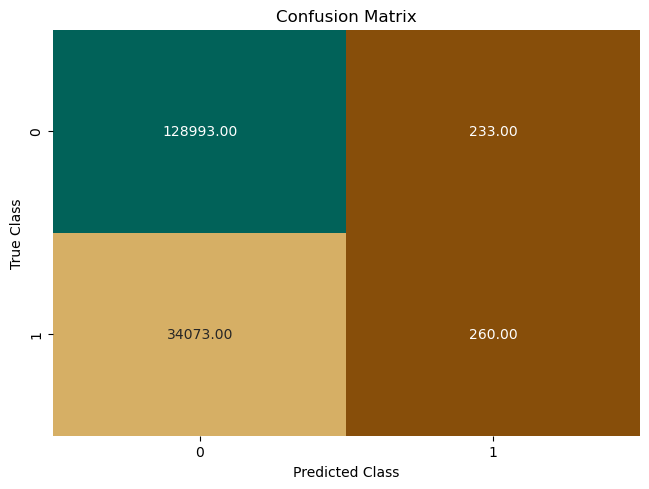

Sensitivity or TPR: 0.7572889057175313%
Specificity or TNR: 99.81969572686612%
Precision: 52.73833671399595%
Negative Predictive Value: 79.10477965976966%
False Positive Rate: 0.18030427313388947%
False Negative Rate: 99.24271109428247%
False Discovery Rate: 47.26166328600406%
Accuracy: 79.0253058529338%
Validation AUC 0.5028849231629182
Figure(640x480)


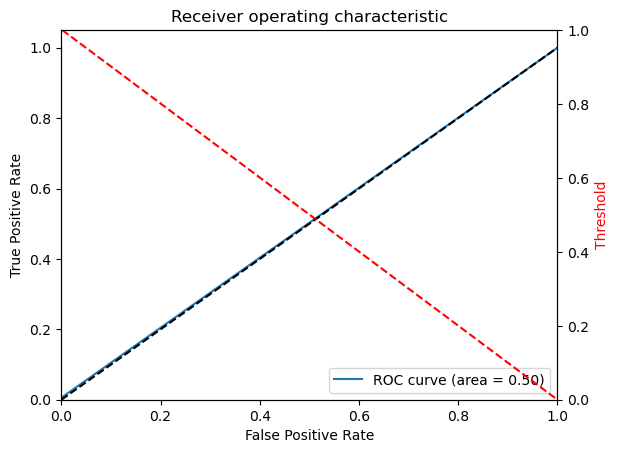

<Figure size 640x480 with 0 Axes>

In [16]:
test_labels = test_v1.iloc[:,0]
test_labels.head()
# Apply the binary conversion function to the 'target' column
target_predicted_binary_v1 = predictions_v1['predicted'].apply(lambda x: binary_convert(x))
# Display the first 10 binary predictions
print(target_predicted_binary_v1.head(10))
print(test_v1.iloc[:, :2].head(10)) 


plot_confusion_matrix(test_labels, target_predicted_binary_v1)
plot_roc(test_labels, target_predicted_binary_v1)

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: predicted, dtype: int64
         target  Distance
1496224       0     731.0
220208        0    1744.0
851482        1     862.0
1051884       0     602.0
1173288       0    1744.0
283667        0    1379.0
728479        0    1773.0
636889        1     936.0
345599        1     862.0
185103        0    1946.0


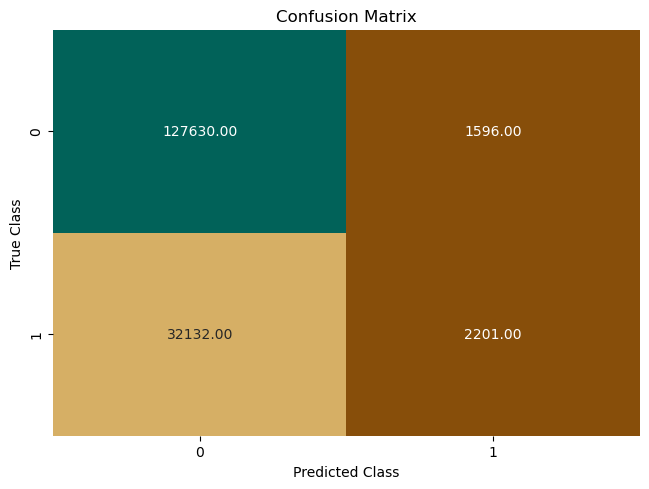

Sensitivity or TPR: 6.410741851862639%
Specificity or TNR: 98.76495442093697%
Precision: 57.966815907295235%
Negative Predictive Value: 79.88758277938433%
False Positive Rate: 1.2350455790630368%
False Negative Rate: 93.58925814813736%
False Discovery Rate: 42.033184092704765%
Accuracy: 79.37869514976246%
Validation AUC 0.5258784813639981
Figure(640x480)


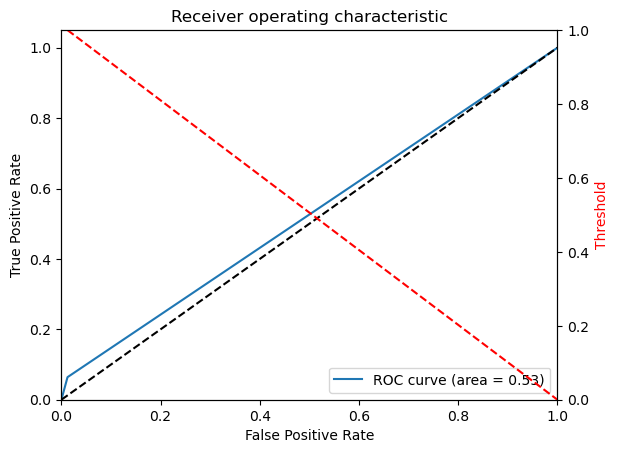

<Figure size 640x480 with 0 Axes>

In [19]:
test_labels = test_v2.iloc[:,0]
test_labels.head()
# Apply the binary conversion function to the 'target' column
target_predicted_binary_v2 = predictions_v2['predicted'].apply(lambda x: binary_convert(x))
# Display the first 10 binary predictions
print(target_predicted_binary_v2.head(10))
print(test_v2.iloc[:, :2].head(10)) 
plot_confusion_matrix(test_labels, target_predicted_binary_v2)
plot_roc(test_labels, target_predicted_binary_v2)

# Step 3: Build and evaluate ensembe models

Write code to perform the follwoing steps:
1. Split data into training, validation and testing sets (70% - 15% - 15%).
2. Use xgboost estimator to build a classifcation model.
3. Host the model on another instance
4. Perform batch transform to evaluate the model on testing data
5. Report the performance metrics that you see better test the model performance 
6. write down your observation on the difference between the performance of using the simple and ensemble models.
Note: You are required to perform the above steps on the two combined datasets separatey.

In [9]:
#1.Split data into training, validation and testing sets (70% - 15% - 15%).
train_v1, test_v1, validate_v1 = split_data(data_v1)
print("Dataset 1:",train_v1.shape, test_v1.shape, validate_v1.shape)
train_v2, test_v2, validate_v2 = split_data(data_v2)
print("Dataset 2:",train_v2.shape, test_v2.shape, validate_v2.shape)

Dataset 1: (1308472, 94) (163559, 94) (163559, 94)
Dataset 2: (1308472, 107) (163559, 107) (163559, 107)


In [8]:
# 2.Use XGBoost Estimator to Build a Classification Model
import boto3
import sagemaker
import io
import os

def upload_and_train(train_data, test_data, validate_data, bucket, prefix='flight'):
    """
    Uploads split data to S3 and trains an XGBoost model on SageMaker.
    
    Parameters:
    - train_data: Training data dataframe
    - test_data: Testing data dataframe
    - validate_data: Validation data dataframe
    - bucket: S3 bucket name
    - prefix: S3 prefix for organizing data and model
    """
    
    # File names
    train_file = f'{prefix}_flight_delay_train.csv'
    test_file = f'{prefix}_flight_delay_test.csv'
    validate_file = f'{prefix}_flight_delay_validate.csv'
    
    # Function to upload data to S3
    s3_resource = boto3.Session().resource('s3')
    def upload_s3_csv(filename, folder, dataframe):
        csv_buffer = io.StringIO()
        dataframe.to_csv(csv_buffer, header=False, index=False)
        s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())
    
    # Upload data to S3
    upload_s3_csv(train_file, 'train', train_data)
    upload_s3_csv(test_file, 'test', test_data)
    upload_s3_csv(validate_file, 'validate', validate_data)
    
    # Define XGBoost container and hyperparameters
    container = retrieve('xgboost', boto3.Session().region_name, '1.0-1')
    hyperparams = {
        "num_round": "42",
        "eval_metric": "auc",
        "objective": "binary:logistic",
        "early_stopping_rounds": "10"
    }
    
    # Initialize the XGBoost model
    s3_output_location = "s3://{}/{}/output/".format(bucket, prefix)
    xgb_model = sagemaker.estimator.Estimator(container,
                                              sagemaker.get_execution_role(),
                                              instance_count=1,
                                              instance_type='ml.m5.2xlarge', #Host the model on another instance
                                              output_path=s3_output_location,
                                              hyperparameters=hyperparams,
                                              sagemaker_session=sagemaker.Session())
    
    # Create data channels for SageMaker
    train_channel = sagemaker.inputs.TrainingInput("s3://{}/{}/train/".format(bucket, prefix), content_type='text/csv')
    validate_channel = sagemaker.inputs.TrainingInput("s3://{}/{}/validate/".format(bucket, prefix), content_type='text/csv')
    data_channels = {'train': train_channel, 'validation': validate_channel}
    
    # Train the model
    xgb_model.fit(inputs=data_channels, logs=False)
    print('Training completed!')

    # Deploy the model (optional, if you want to deploy after training)
    xgb_predictor = xgb_model.deploy(initial_instance_count=1,
                                 serializer=sagemaker.serializers.CSVSerializer(),
                                 instance_type='ml.m5.2xlarge')
    print('Model deployed!')

    # Return both the model and the predictor
    return xgb_model, xgb_predictor


In [10]:
%%time
# Call the function for the data_v2 dataset:
prefix_v1='flight_v1'
model_v1,predictor_v1=upload_and_train(train_v1, test_v1, validate_v1, bucket, prefix=prefix_v1)


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2023-11-02-13-23-55-038



2023-11-02 13:23:55 Starting - Starting the training job.......
2023-11-02 13:24:40 Starting - Preparing the instances for training...........
2023-11-02 13:25:41 Downloading - Downloading input data........
2023-11-02 13:26:21 Training - Training image download completed. Training in progress.................
2023-11-02 13:27:47 Uploading - Uploading generated training model.
2023-11-02 13:27:59 Completed - Training job completed

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-11-02-13-28-02-543



Training completed!


INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2023-11-02-13-28-02-543
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2023-11-02-13-28-02-543


----!Model deployed!
CPU times: user 25.2 s, sys: 323 ms, total: 25.5 s
Wall time: 7min 7s


In [11]:
%%time
# Call the function for the data_v2 dataset:
prefix_v2='flight_v2'
model_v2,predictor_v2=upload_and_train(train_v2, test_v2, validate_v2, bucket, prefix=prefix_v2)


INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2023-11-02-13-31-07-846



2023-11-02 13:31:08 Starting - Starting the training job..
2023-11-02 13:31:26 Starting - Preparing the instances for training..............
2023-11-02 13:32:41 Downloading - Downloading input data..........
2023-11-02 13:33:37 Training - Training image download completed. Training in progress.................
2023-11-02 13:35:02 Uploading - Uploading generated training model.
2023-11-02 13:35:14 Completed - Training job completed

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-11-02-13-35-15-324



Training completed!


INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2023-11-02-13-35-15-324
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2023-11-02-13-35-15-324


----!Model deployed!
CPU times: user 30.6 s, sys: 433 ms, total: 31 s
Wall time: 7min 12s


In [ ]:
#3. Host the Model on Another Instance


In [12]:
#Preform Prediction for model 1
print("Shape of test set;",test_v1.shape)
row = test_v1.iloc[0:1,1:]
row.head()
batch_X_csv_buffer = io.StringIO()
row.to_csv(batch_X_csv_buffer, header=False, index=False)
test_row = batch_X_csv_buffer.getvalue()
predictor_v1.predict(test_row) #The result you get isn't a *0* or a *1*. Instead, you get a *probability score*.


Shape of test set; (163559, 94)


b'0.12125302106142044'

In [13]:
#Preform Prediction for model 2
print("Shape of test set;",test_v2.shape)
row = test_v2.iloc[0:1,1:]
row.head()
batch_X_csv_buffer = io.StringIO()
row.to_csv(batch_X_csv_buffer, header=False, index=False)
test_row = batch_X_csv_buffer.getvalue()
predictor_v2.predict(test_row) #The result you get isn't a *0* or a *1*. Instead, you get a *probability score*.

Shape of test set; (163559, 107)


b'0.08979212492704391'

In [14]:
#Terminating the deployed model
predictor_v1.delete_endpoint(delete_endpoint_config=True)
predictor_v2.delete_endpoint(delete_endpoint_config=True)


INFO:sagemaker:Deleting endpoint configuration with name: sagemaker-xgboost-2023-11-02-13-28-02-543
INFO:sagemaker:Deleting endpoint with name: sagemaker-xgboost-2023-11-02-13-28-02-543
INFO:sagemaker:Deleting endpoint configuration with name: sagemaker-xgboost-2023-11-02-13-35-15-324
INFO:sagemaker:Deleting endpoint with name: sagemaker-xgboost-2023-11-02-13-35-15-324


In [23]:
%%time
## 4. Perform Batch Transform to Evaluate the Model on Testing Data
#Batch transform for v1 model
batch_X = test_v1.iloc[:,1:];
batch_X.head()
batch_X_file='batch-in.csv'
upload_s3_csv(batch_X_file, 'batch-in', batch_X,prefix_v1)
batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix_v1)
batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix_v1,batch_X_file)

xgb_transformer_v1 = model_v1.transformer(instance_count=1,
                                       instance_type='ml.m5.2xlarge',
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)

xgb_transformer_v1.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')
xgb_transformer_v1.wait()

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-11-02-13-40-10-893
INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2023-11-02-13-40-11-644


..................................[2023-11-02:13:45:54:INFO] No GPUs detected (normal if no gpus installed)
[2023-11-02:13:45:54:INFO] No GPUs detected (normal if no gpus installed)
[2023-11-02:13:45:54:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2023-11-02 13:45:55 +0000] [27] [INFO] Starting g

In [28]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix_v1,'batch-in.csv.out'))
target_predicted_v1 = pd.read_csv(io.BytesIO(obj['Body'].read()),sep=',',names=['target'])
target_predicted_v1.head(5)

target
0  0.121253
1  0.187601
2  0.334971
3  0.054375
4  0.291060

In [54]:
%%time
#Batch transform for v2 model
batch_X = test_v2.iloc[:,1:];
batch_X.head()
batch_X_file='batch-in.csv'
upload_s3_csv(batch_X_file, 'batch-in', batch_X,prefix_v2)
batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix_v2)
batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix_v2,batch_X_file)

xgb_transformer_v2 = model_v2.transformer(instance_count=1,
                                       instance_type='ml.m5.2xlarge',
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)

xgb_transformer_v2.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')
xgb_transformer_v2.wait()



INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-11-02-14-02-43-211
INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2023-11-02-14-02-43-991


..................................[2023-11-02:14:08:22:INFO] No GPUs detected (normal if no gpus installed)
[2023-11-02:14:08:22:INFO] No GPUs detected (normal if no gpus installed)
[2023-11-02:14:08:22:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2023-11-02 14:08:23 +0000] [27] [INFO] Starting g

In [55]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix_v2,'batch-in.csv.out'))
target_predicted_v2 = pd.read_csv(io.BytesIO(obj['Body'].read()),sep=',',names=['target'])
target_predicted_v2.head(5)

target
0  0.089792
1  0.185466
2  0.275043
3  0.050997
4  0.202371

In [47]:
## 5. Report the Performance Metrics 
# Apply the binary conversion function to the 'target' column
target_predicted_binary_v1 = target_predicted_v1['target'].apply(lambda x: binary_convert(x))

# Display the first 10 binary predictions
print(target_predicted_binary_v1.head(10))
print(test_v1.iloc[:, :2].head(10)) 


0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: target, dtype: int64
         target  Distance
1496224       0     731.0
220208        0    1744.0
851482        1     862.0
1051884       0     602.0
1173288       0    1744.0
283667        0    1379.0
728479        0    1773.0
636889        1     936.0
345599        1     862.0
185103        0    1946.0


In [50]:
test_labels = test_v1.iloc[:,0]
test_labels.head()

1496224    0
220208     0
851482     1
1051884    0
1173288    0
Name: target, dtype: int64

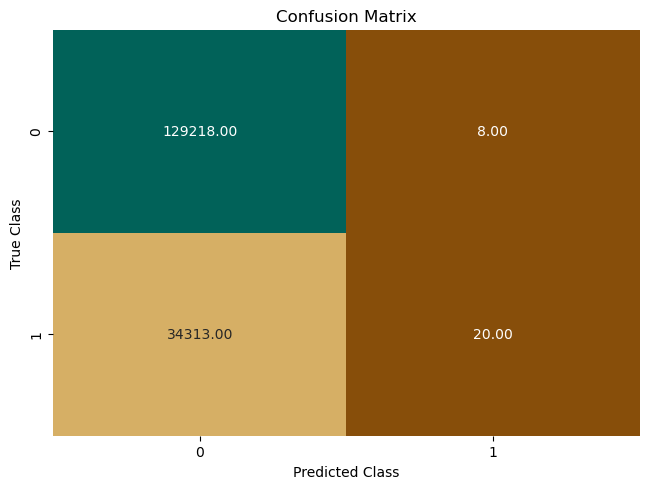

Sensitivity or TPR: 0.058252992747502404%
Specificity or TNR: 99.99380929534304%
Precision: 71.42857142857143%
Negative Predictive Value: 79.01743400333882%
False Positive Rate: 0.006190704656957578%
False Negative Rate: 99.9417470072525%
False Discovery Rate: 28.57142857142857%
Accuracy: 79.01613485042095%
Validation AUC 0.5002603114404527
Figure(640x480)


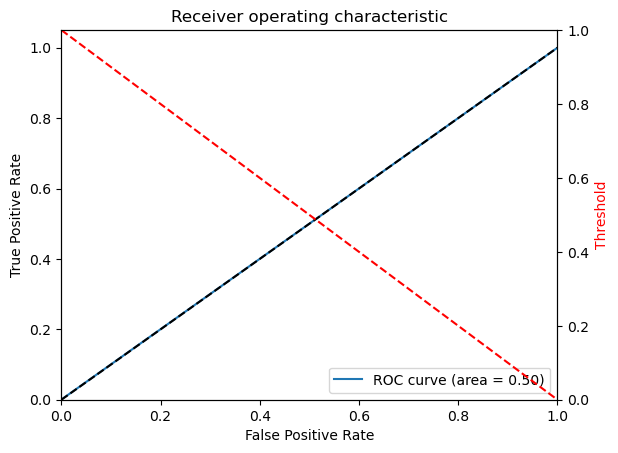

<Figure size 640x480 with 0 Axes>

In [53]:
plot_confusion_matrix(test_labels, target_predicted_binary_v1)
plot_roc(test_labels, target_predicted_binary_v1)

In [58]:
# Apply the binary conversion function to the 'target' column
target_predicted_binary_v1 = target_predicted_v1['target'].apply(lambda x: binary_convert(x))


In [59]:
# Apply the binary conversion function to the 'target' column
target_predicted_binary_v2 = target_predicted_v2['target'].apply(lambda x: binary_convert(x))

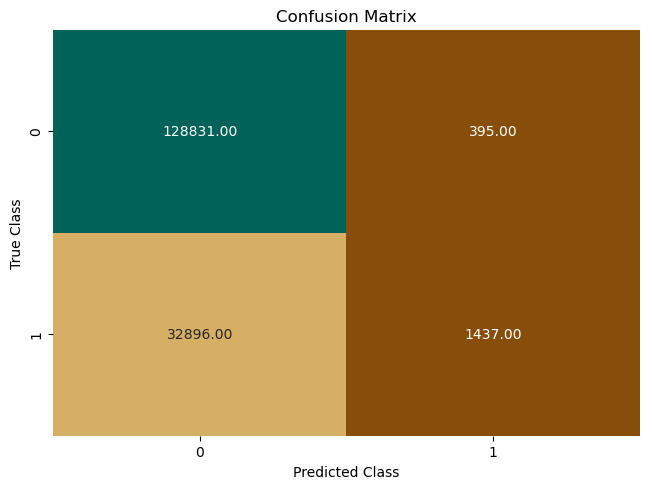

Sensitivity or TPR: 4.185477528908048%
Specificity or TNR: 99.69433395756272%
Precision: 78.43886462882097%
Negative Predictive Value: 79.65954973504734%
False Positive Rate: 0.30566604243728046%
False Negative Rate: 95.81452247109196%
False Discovery Rate: 21.561135371179038%
Accuracy: 79.6458770229703%
Validation AUC 0.5193990574323538
Figure(640x480)


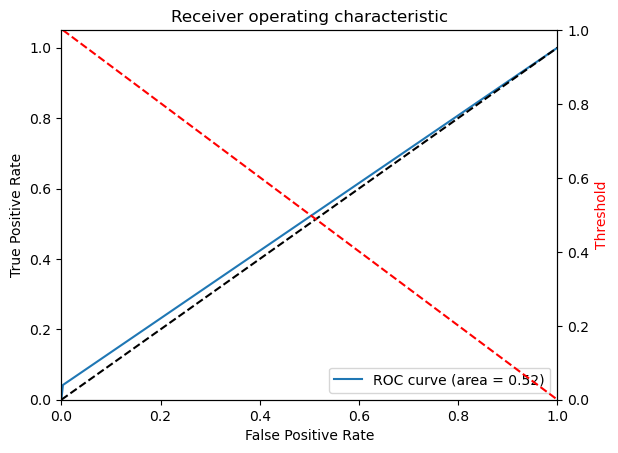

<Figure size 640x480 with 0 Axes>

In [60]:
plot_confusion_matrix(test_labels, target_predicted_binary_v2)
plot_roc(test_labels, target_predicted_binary_v2)

**Comparison of Logistic Regression vs. XGBoost:**

- **Accuracy:** XGBoost marginally outperforms logistic regression.

- **Precision (for class 1.0):** XGBoost maintains high precision across both datasets while logistic regression shows high precision on one and low on the other.

- **Recall (for class 1.0):** XGBoost has a notably better recall than logistic regression, indicating it is more adept at identifying true positives.

- **F1-score (for class 1.0):** XGBoost again shows higher F1-scores, suggesting a better balance between precision and recall compared to logistic regression.

**Summary:** 

The XGBoost models demonstrate high precision but very low sensitivity, indicating they can predict flight delays accurately when they do, but they miss a large number of actual delays. Despite their accuracy, the models' performance is close to random guessing based on the AUC values. Model 2 shows a slight advantage over Model 1 with marginally better metrics. For practical use, these models would require further tuning to balance the ability to detect more true positives without significantly increasing false positives.
